In [1]:
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import gsd
import hoomd
from utils.cg_utils import gsd_rdf
from utils.draw_scene import snap_render, display_movie
import numpy as np
import matplotlib.pyplot as plt
import freud

/home/chris/miniconda3/envs/mosdev/lib/python3.7/site-packages/hoomd/meta.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [21]:
# Use Hoomd to build a simple LJ-particle system:

def build_system(packing='bcc'):
    '''
    Generate a simple LJ particle system using hoomd's create_lattice function
    packing 
    '''
    if packing == 'fcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.fcc(a=1.58)), n=6)
    elif packing == 'bcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.bcc(a=1.29)), n=6)
    hoomd.dump.gsd('{}_system.gsd'.format(packing), group = hoomd.group.all(), period=None, overwrite=True)
    return system


def hoomd_simulation(packing, temp):
    
    hoomd.context.initialize("")
    system = build_system(packing)
    nl = hoomd.md.nlist.cell()
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
    lj.pair_coeff.set('A', 'A', alpha=1.0, epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.001)
    _all = hoomd.group.all()
    nvt = hoomd.md.integrate.nvt(group=_all, kT=temp, tau=1)
    nvt.randomize_velocities(seed=23)
    hoomd.analyze.log(filename='out.log',
                      quantities=["time", "temperature", "potential_energy"],
                      period=100,
                      overwrite=True
                     )
    hoomd.dump.gsd('{}-{}kT-trajectory.gsd'.format(packing, temp), period=5e3, group=_all, overwrite=True)
    hoomd.run(3e5)


def rdf_from_gsd(gsd_file, r_max=None, r_min=0.1, nbins=50):
    f = gsd.pygsd.GSDFile(open(gsd_file, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    
    if r_max is None:
        r_max = max(trajectory[0].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory:
        freud_rdf.compute(system=frame, reset=False)
    return freud_rdf

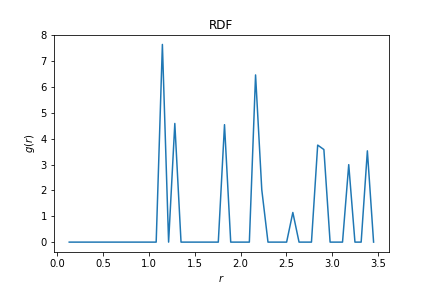

In [9]:
# RDF of a generated bcc system without any simulation
bcc_rdf = rdf_from_gsd('trajectories/bcc_system.gsd')
bcc_rdf

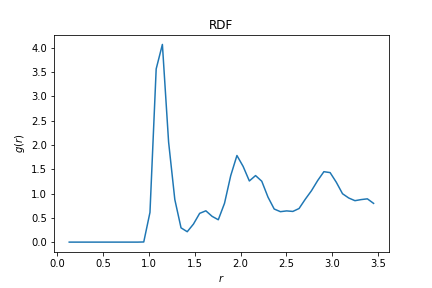

In [16]:
bcc_cold_rdf = rdf_from_gsd('trajectories/bcc-cold.gsd')
bcc_cold_rdf

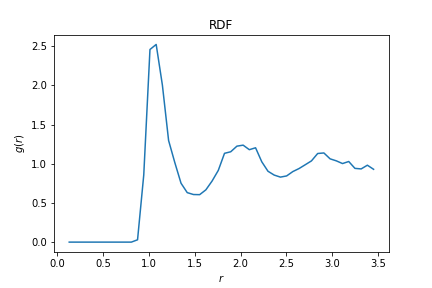

In [20]:
bcc_mid_rdf =  rdf_from_gsd('trajectories/bcc-mid.gsd')
bcc_mid_rdf

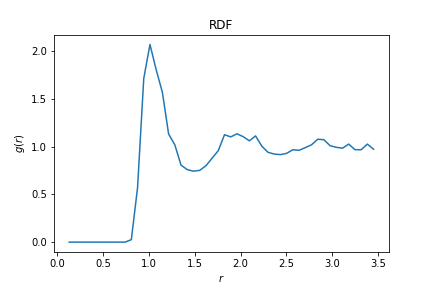

In [17]:
bcc_hot_rdf =  rdf_from_gsd('trajectories/bcc-hot.gsd')
bcc_hot_rdf

In [22]:
# Below here, have some interactive steps.  Choose between BCC and FCC and generate a system
# Run a simulation with that system what whatever temperature you want, see the RDF